# Anomaly Detection with `aeon`

ใน Part นี้จะสอนใช้ library ที่ชื่อ AEON ซึ่งมี part สำหรับ Anomaly detection
Document : https://www.aeon-toolkit.org/en/stable/


Input data format:
สำหรับ Lab นี้เราจะกำหนดให้ `m` เป็นขนาดของ time series หรือจำนวน data points. หมายเหตุใน Lab นี้จะมุุ่งเน้น **Univariate** time series เราสามารถกำหนดตัวแปร time series ได้หลายรูปแบบ:

   - `np.ndarray`, shape `(m,)`, `(m, 1)`,  `(1, m)`
   - `pd.DataFrame`, shape `(m, 1)`, `(1, m)`
   - `pd.Series`, shape `(m,)`.

แต่ในกรณีที่ **Multivariate** time series เราสามารเพิ่ม `d` สำหรับจำนวน channels ของ time series.

Output data format:

- Anomaly **scores** (default):
  `np.ndarray`, shape `(m,)` of type `float`. สำหรับแต่ละ index จะแสดงค่า anomaly score (float) เพื่อวัดคะแนนการเกิดเหตุการณ์ผิดปกติ (คะแนนสูงมีโอกาสเป็นค่าผิดปกติ)

(บาง method จะมี output เป็น `Binary classification` แต่ใน lab วันนี้จะเน้นในกรณี `Anomaly scores`)
- **Binary** classification:
  `np.ndarray`, shape `(m,)` of type `bool` or `int`. สำหรับแต่ละ index จะแสดง class ที่เกิดขึ้นว่าเป็นค่าผิดปกติหรือเป็นค่าปกติ โดย:
        - `True`/`1` แทน class ผิดปกติ (anomalous)
        - `False`/`0` แทน class ไม่ผิดปกติ




In [70]:
!pip install aeon matplotlib seaborn pyod stumpy prts pytouch 



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
from aeon.datasets import load_anomaly_detection
from aeon.benchmarking.metrics.anomaly_detection import range_pr_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Pattern การใข้งาน TSAD จาก AEON

Methods:

   -   Unsupervised (default): ไม่ต้องการ **train** ดังนั้นสามารเรียกใช้งาน function `fit_predict` สำหรับการตรวจจับค่าผิด

   -  Semi-supervised: ต้อง train เฉพาะข้อมูลที่**ไม่มีค่าผิดปกติ** ดังนั้นขั้นแรกการ train ข้อมูลจะต้องป้อน time series ไม่มีค่าผิดปกติ และ `ANS` เป็น 0 ทั้งหมดโดยใช้ function `fit` จากนั้นจึงเรียก function `predict` สำหรับตรวจจับค่าผิดปกติ

   -   Supervised: ต้อง train ข้อมูลที่　**มีทั้งค่าผิดปกติและค่าปกติ** ดังนั้นขั้นแรกการ train ข้อมูลจะต้องป้อน time series ไม่มีค่าผิดปกติ และ `ANS` มีทั้ง 0 และ 1 เสมอโดยใช้function `fit` แบบเดียวกับ Semi-supervised จากนั้นจึงเรียก function `predict` สำหรับตรวจจับค่าผิดปกติตามลำดับ


Evaluation metric:

 -  สำหรับ Lab ในครั้งนี้จะใช้ Evaluation metric คือ `Range-Precision-Recall-AUC` [1] ถ้าเข้าใกล้ 1 แสดงว่ามีความแม่นยำสูง ถ้าใกล้ 0 ความแม่นยำต่ำ


References

[1]
J. Paparrizos et al. Volume Under the Surface: A New Accuracy Evaluation Measure for Time-Series Anomaly Detection. PVLDB, 15(11), 2022. doi:10.14778/3551793.3551830


## Sample dataset

สำหรับรายชื่อ Dataset ทั้งหมด สามารถค้นหาได้ที่ > https://timeeval.github.io/evaluation-paper/notebooks/Datasets.html

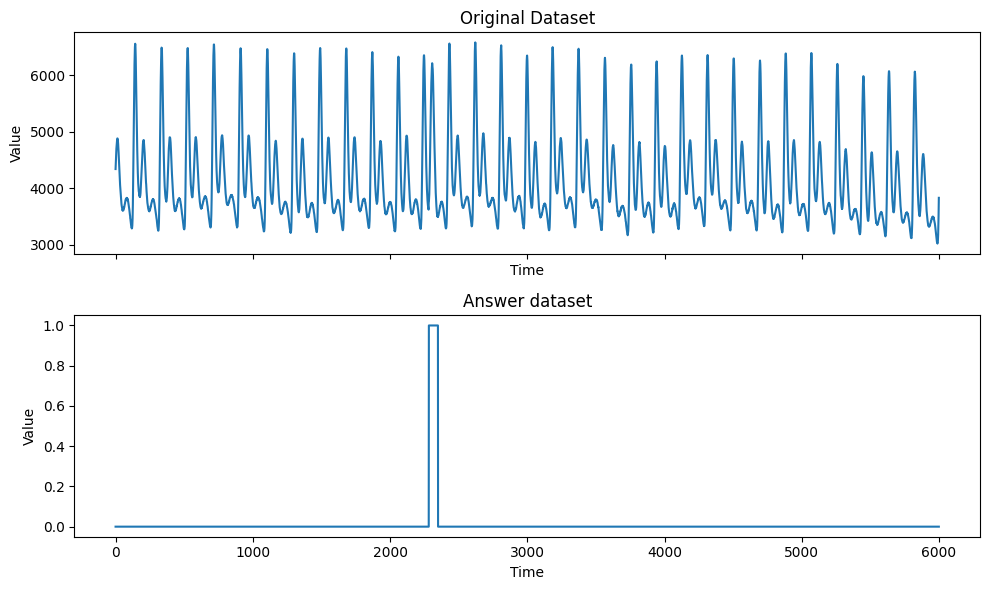

In [72]:
TS, ANS = load_anomaly_detection(
    name=("KDD-TSAD", "197_UCR_Anomaly_tiltAPB1")   ## เปลี่ยนชื่อ Dataset ได้
    # name=("MGAB", "1")   ## เปลี่ยนชื่อ Dataset ได้
)  
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
TS = TS[112000:118000]
ANS = ANS[112000:118000]
axes[0].plot(TS)
axes[0].set_title("Original Dataset")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

axes[1].plot(ANS)
axes[1].set_title("Answer dataset")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Value')

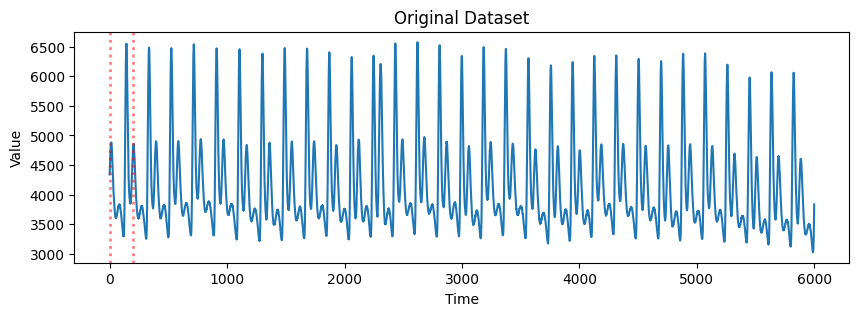

In [73]:
## set window size

window_size = 200
plt.figure(figsize=(10, 3))
plt.plot(TS)
plt.title("Original Dataset")
plt.axvline(x=0, color='red', linestyle=':', linewidth=2, alpha=0.5)
plt.axvline(x=window_size-1, color='red', linestyle=':', linewidth=2, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Value")

## Matrix Profile

Matrix profile (Unsupervised, Distance Methods)

REF: Y. Zhu et al., Matrix Profile II: Exploiting a Novel Algorithm and GPUs to Break the One Hundred Million Barrier for Time Series Motifs and Joins, IEEE 16th International Conference on Data Mining (ICDM), 2016. doi: 10.1109/ICDM.2016.0085.



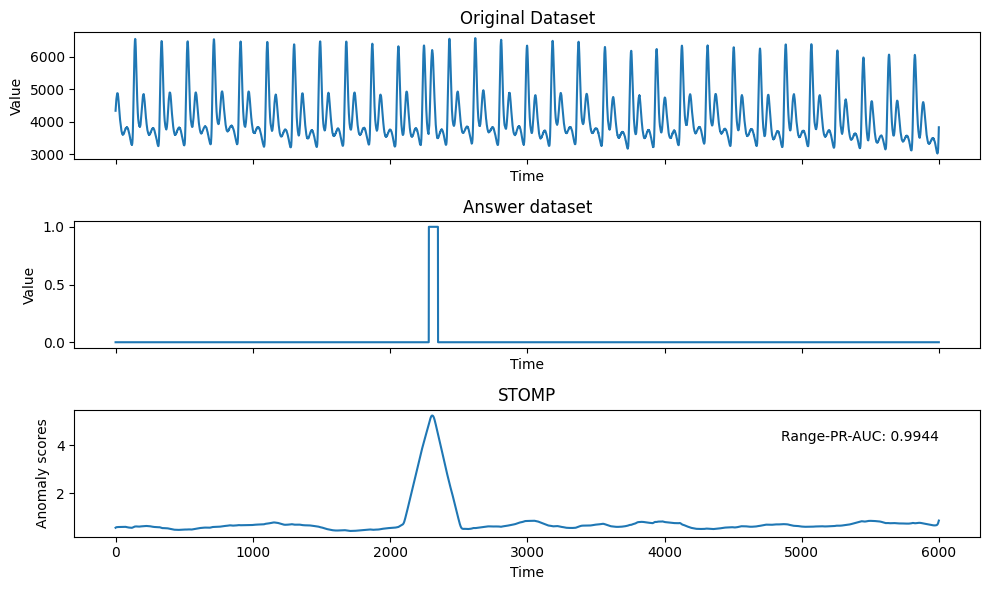

In [74]:
from aeon.anomaly_detection import STOMP

MP_TSAD = STOMP(window_size=window_size)
scores = MP_TSAD.fit_predict(TS)
quality = range_pr_auc_score(ANS, scores)

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
axes[0].plot(TS)
axes[0].set_title("Original Dataset")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

axes[1].plot(ANS)
axes[1].set_title("Answer dataset")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")

axes[2].plot(scores)
axes[2].set_title("STOMP")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Anomaly scores")
axes[2].text(len(TS), np.max(scores)/5*4, f"Range-PR-AUC: {quality:.4f}", ha="right")

plt.tight_layout()
plt.show()

# AutoEncoder

AutoEncoder (Reconstruction-based, semi-supervised)

Ref: C. C. Aggarwal. Outlier analysis. In Data mining, 75–79. Springer, 2015.

Training: 100%|██████████| 50/50 [00:03<00:00, 14.00it/s]


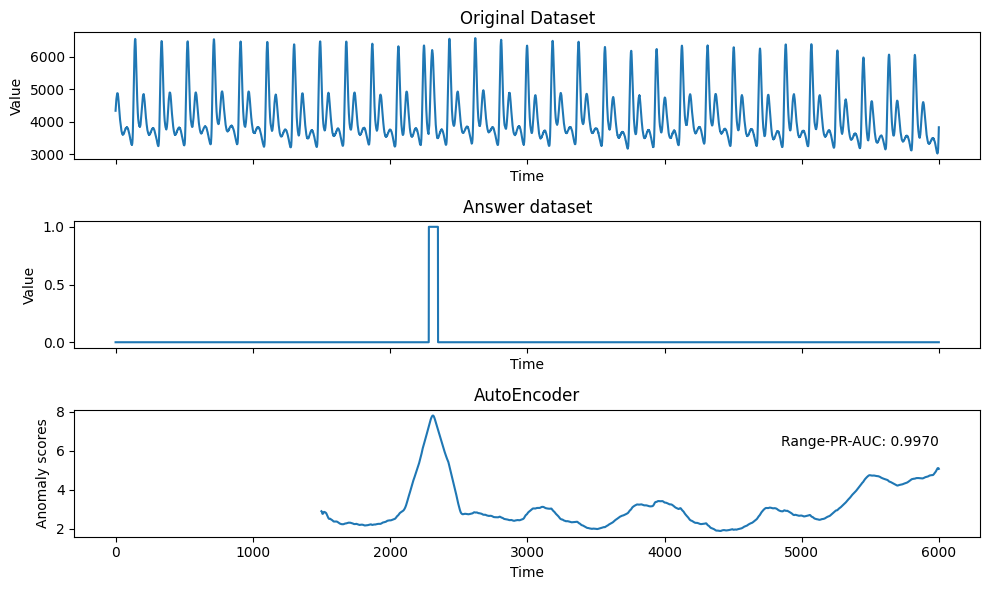

In [75]:
from aeon.anomaly_detection import PyODAdapter
from pyod.models.auto_encoder import AutoEncoder

TS_train = TS[:1500]
ANS_train = ANS[:1500]
TS_pred = TS[1500:]
ANS_pred = ANS[1500:]

encode_TSAD = PyODAdapter(AutoEncoder(epoch_num=50), window_size=window_size, stride=1)
# สร้างโมเดลจาก TS ที่ไม่มี Anomalies
encode_TSAD.fit(TS_train)

# pred ts จากข้อมูลที่แยกออกมา
scores = encode_TSAD.predict(TS_pred)
quality = range_pr_auc_score(ANS_pred, scores)

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
axes[0].plot(TS)
axes[0].set_title("Original Dataset")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

axes[1].plot(ANS)
axes[1].set_title("Answer dataset")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")

axes[2].plot( range(1500,len(TS)), scores)
axes[2].set_title("AutoEncoder")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Anomaly scores")
axes[2].text(len(TS), np.max(scores)/5*4, f"Range-PR-AUC: {quality:.4f}", ha="right")

plt.tight_layout()
plt.show()


# DWT_MLEAD

Discrete Wavelet Transform maximum likelihood estimation for anomaly detection (Distribution Methods, Unsupervised)

REF: M. Thill,  W. Konen, and T. Bäck. “Time Series Anomaly Detection with Discrete Wavelet Transforms and Maximum Likelihood Estimation.” In Proc. Int' Conference on Time Series (ITISE), 2017



D:\git_project\teaching\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
D:\git_project\teaching\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract


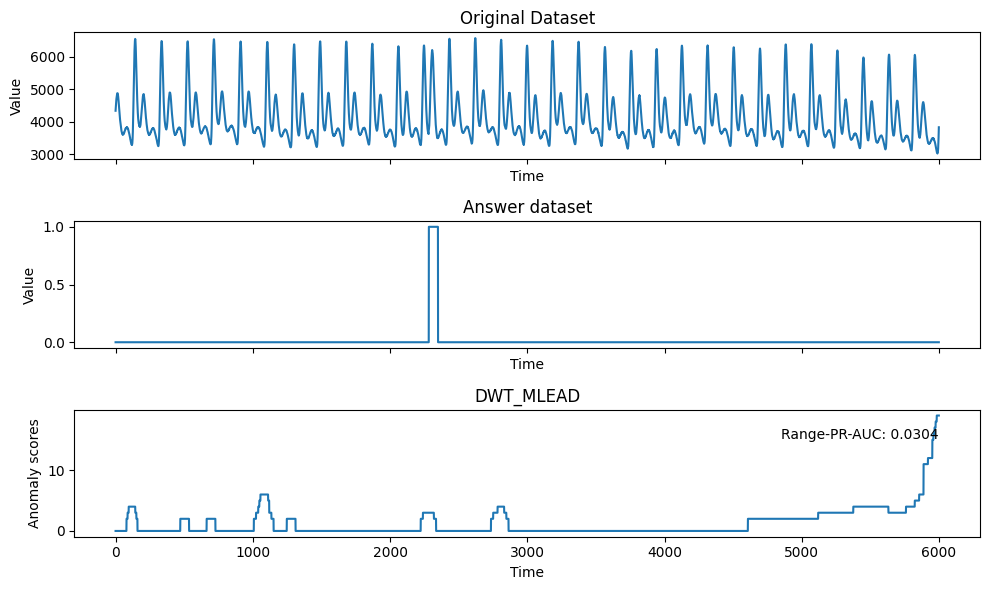

In [76]:
from aeon.anomaly_detection import DWT_MLEAD

DWT_TSAD = DWT_MLEAD(quantile_boundary_type='percentile', quantile_epsilon=0.01)
scores = DWT_TSAD.fit_predict(TS)
quality = range_pr_auc_score(ANS, scores)

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
axes[0].plot(TS)
axes[0].set_title("Original Dataset")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

axes[1].plot(ANS)
axes[1].set_title("Answer dataset")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")

axes[2].plot(scores)
axes[2].set_title("DWT_MLEAD")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Anomaly scores")
axes[2].text(len(TS), np.max(scores)/5*4, f"Range-PR-AUC: {quality:.4f}", ha="right")

plt.tight_layout()
plt.show()

# Copula-Based Outlier Detection (COPOD)

COPOD (Distribution Methods, Unsupervised)

REF Zheng Li, Yue Zhao, Nicola Botta, Cezar Ionescu, and Xiyang Hu. COPOD: copula-based outlier detection. In IEEE International Conference on Data Mining (ICDM). IEEE, 2020.

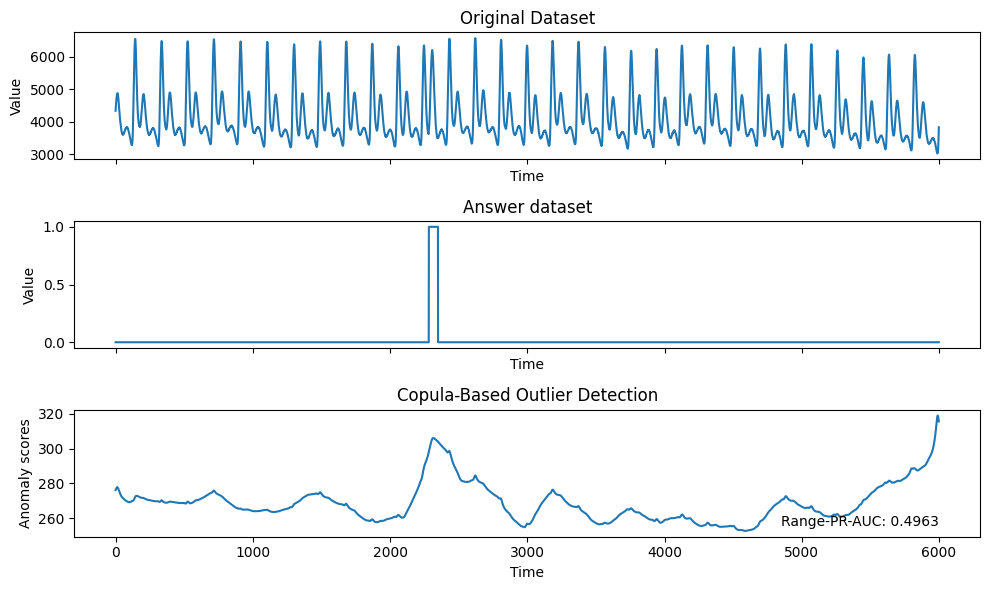

In [77]:
from aeon.anomaly_detection import COPOD


COPOD_TSAD = COPOD(window_size=window_size, stride=1)
scores = COPOD_TSAD.fit_predict(TS)
quality = range_pr_auc_score(ANS, scores)

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
axes[0].plot(TS)
axes[0].set_title("Original Dataset")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

axes[1].plot(ANS)
axes[1].set_title("Answer dataset")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")

axes[2].plot(scores)
axes[2].set_title("Copula-Based Outlier Detection")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Anomaly scores")
axes[2].text(len(TS), np.max(scores)/5*4, f"Range-PR-AUC: {quality:.4f}", ha="right")

plt.tight_layout()
plt.show()

# Isolation Forest

Isolation Forest (Tree, unsupervised or `semi-supervised`)



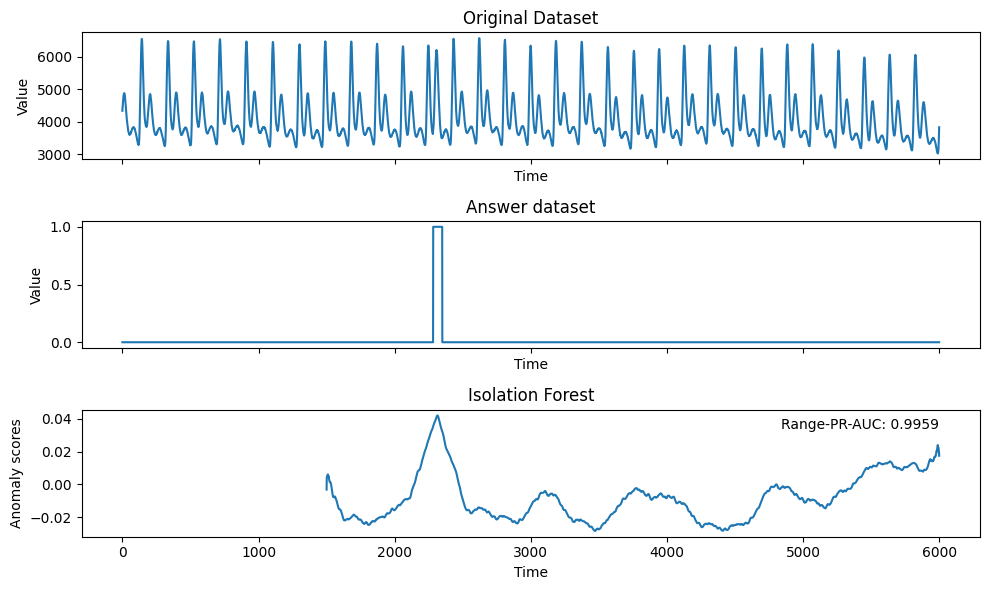

In [78]:
from aeon.anomaly_detection import IsolationForest

TS_train = TS[:1500]
ANS_train = ANS[:1500]
TS_pred = TS[1500:]
ANS_pred = ANS[1500:]

IF_TSAD = IsolationForest(window_size=window_size, stride=1)
IF_TSAD.fit(TS_train)

scores = IF_TSAD.predict(TS_pred)
quality = range_pr_auc_score(ANS_pred, scores)

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
axes[0].plot(TS)
axes[0].set_title("Original Dataset")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

axes[1].plot(ANS)
axes[1].set_title("Answer dataset")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")

axes[2].plot( range(1500,len(TS)), scores)
axes[2].set_title("Isolation Forest")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Anomaly scores")
axes[2].text(len(TS), np.max(scores)/5*4, f"Range-PR-AUC: {quality:.4f}", ha="right")

plt.tight_layout()
plt.show()


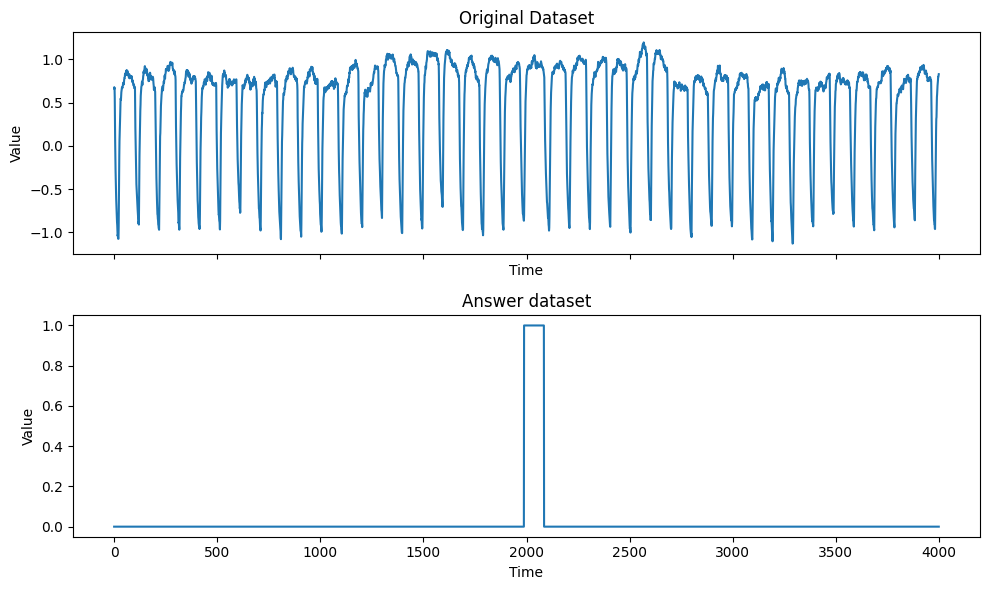

In [79]:
## เพิ่ม Dataset
TS2, ANS2 = load_anomaly_detection(
    name=("KDD-TSAD", "048_UCR_Anomaly_DISTORTEDTkeepFifthMARS")   ## เปลี่ยนชื่อ Dataset ได้
)  

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
TS2 = TS2[4000:8000]
ANS2 = ANS2[4000:8000]
axes[0].plot(TS2)
axes[0].set_title("Original Dataset")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

axes[1].plot(ANS2)
axes[1].set_title("Answer dataset")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
plt.tight_layout()
plt.show()


In [80]:
from aeon.benchmarking.metrics.anomaly_detection import f_score_at_k_ranges, range_roc_auc_score, range_pr_auc_score


detectors = {
    "STOMP": STOMP(window_size=window_size),
    "DWT_MLEAD": DWT_MLEAD(quantile_boundary_type='percentile', quantile_epsilon=0.01),
    "COPOD": COPOD(window_size=window_size, stride=1),
    # ! Attention ! we use the IsolationForest and AutoEncoder unsupervised, which is not recommended
     "IsolationForest": IsolationForest(window_size=window_size, stride=1),
    "AutoEncode": PyODAdapter(AutoEncoder(), window_size=100)
}
datasets = {
    "tiltAPB1": TS,
    "FifthMARS":TS2
}
ground_truths = {
    "tiltAPB1": ANS,
    "FifthMARS": ANS2
}
scores = {}
metrics = []
for d in datasets:
    scores[d] = {}
    for detector in detectors:
        est = detectors[detector]
        score = est.fit_predict(datasets[d])
        scores[d][detector] = score
        entry = {"dataset": d, "algorithm": detector}
        for m in [f_score_at_k_ranges, range_roc_auc_score, range_pr_auc_score]:
            entry[m.__name__] = m(ground_truths[d], score)
        metrics.append(entry)

D:\git_project\teaching\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
D:\git_project\teaching\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
Training: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]
D:\git_project\teaching\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
D:\git_project\teaching\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
Training: 100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


D:\git_project\teaching\venv\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


(<Figure size 600x240 with 1 Axes>, <Axes: >)

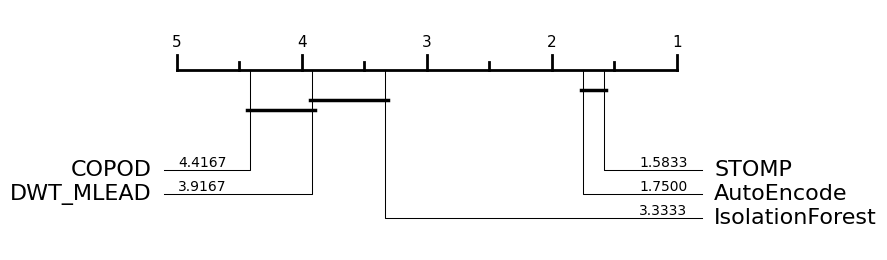

In [81]:
import pandas as pd
from aeon.visualisation import plot_critical_difference

df = (pd.DataFrame(metrics)
      .sort_values("range_pr_auc_score", ascending=False)
      .reset_index(drop=True)
)
cd = df.pivot(index="algorithm", columns="dataset")
methods = cd.index
cd = cd.T
plot_critical_difference(cd.values, methods, textspace=1)